# Tutorial 01: Introduction to Panel Data Structures

**Series**: PanelBox - Fundamentals  
**Level**: Beginner  
**Estimated Time**: 45-60 minutes  
**Prerequisites**: None (this is the first tutorial)

## Learning Objectives

By the end of this tutorial, you will be able to:
- Understand what panel data is and its key characteristics
- Load panel datasets using PanelBox's `PanelData` class
- Validate panel structure (balanced vs unbalanced)
- Inspect entity and time dimensions
- Apply common transformations (demeaning, lags, first differences)
- Visualize panel data structure

## Table of Contents
1. [What is Panel Data?](#1-what-is-panel-data)
2. [Loading Data with PanelBox](#2-loading-data-with-panelbox)
3. [Panel Structure and Validation](#3-panel-structure-and-validation)
4. [Data Transformations](#4-data-transformations)
5. [Visualization Techniques](#5-visualization-techniques)
6. [Practical Exercises](#6-practical-exercises)
7. [Summary and Next Steps](#7-summary-and-next-steps)

---

In [1]:
# Notebook metadata
__version__ = "1.0.0"
__last_updated__ = "2026-02-16"
__compatible_with__ = "PanelBox >= 0.1.0"

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# PanelBox library (development mode)
import sys
sys.path.insert(0, '/home/guhaase/projetos/panelbox')
import panelbox as pb
from panelbox import PanelData

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Display library version
print(f"PanelBox version: {pb.__version__}")
print(f"Notebook version: {__version__}")
print("Setup complete!")

PanelBox version: 1.0.0
Notebook version: 1.0.0
Setup complete!


## 1. What is Panel Data?

Panel data (also called **longitudinal data** or **cross-sectional time-series data**) combines two dimensions:

1. **Cross-sectional dimension** (entities): Firms, individuals, countries, regions, etc.
2. **Time dimension** (periods): Years, quarters, months, days, etc.

### Why Panel Data?

Panel data offers several advantages over pure cross-sectional or time-series data:

✅ **More observations**: N entities × T time periods = N×T observations

✅ **Control for unobserved heterogeneity**: Entity-specific effects (e.g., firm culture, country institutions)

✅ **Richer dynamics**: Study changes over time within the same entity

✅ **Less collinearity**: Variation across both dimensions reduces multicollinearity

✅ **More efficient estimates**: More degrees of freedom, higher power

### Example: Grunfeld Investment Data

We'll use the classic **Grunfeld dataset**:
- **Entities**: 10 large US corporations (General Motors, US Steel, etc.)
- **Time**: 20 years (1935-1954)
- **Variables**: Investment, firm value, capital stock

**Research Question**: What determines corporate investment decisions?

$$
\text{Investment}_{it} = \beta_0 + \beta_1 \text{Value}_{it} + \beta_2 \text{Capital}_{it} + \alpha_i + u_{it}
$$

Where:
- $i$ indexes firms (cross-sectional dimension)
- $t$ indexes years (time dimension)
- $\alpha_i$ captures firm-specific unobserved effects
- $u_{it}$ is the idiosyncratic error term

---

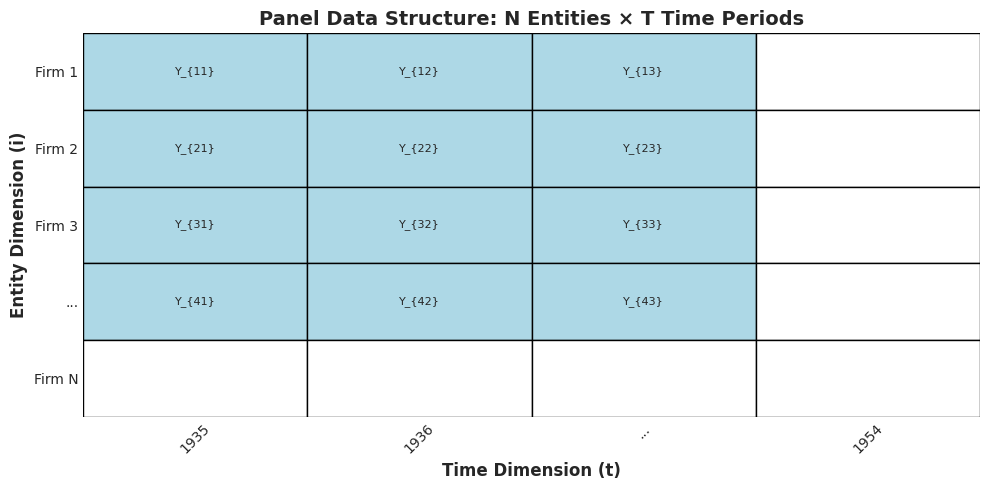

Panel Data = Cross-Section + Time Series
Observations: N (entities) × T (periods) = N×T


In [2]:
# Create a simple illustration of panel structure
fig, ax = plt.subplots(figsize=(10, 5))

# Mock data grid
entities = ['Firm 1', 'Firm 2', 'Firm 3', '...', 'Firm N']
years = ['1935', '1936', '...', '1954']

# Create grid
for i, entity in enumerate(entities):
    for j, year in enumerate(years):
        color = 'lightblue' if i < len(entities)-1 and j < len(years)-1 else 'white'
        ax.add_patch(plt.Rectangle((j, i), 1, 1,
                                    facecolor=color,
                                    edgecolor='black',
                                    linewidth=1))
        if i < len(entities)-1 and j < len(years)-1:
            ax.text(j+0.5, i+0.5, f'Y_{{{i+1}{j+1}}}',
                   ha='center', va='center', fontsize=8)

# Labels
ax.set_xlim(0, len(years))
ax.set_ylim(0, len(entities))
ax.set_xticks(np.arange(len(years)) + 0.5)
ax.set_xticklabels(years, rotation=45)
ax.set_yticks(np.arange(len(entities)) + 0.5)
ax.set_yticklabels(entities)
ax.set_xlabel('Time Dimension (t)', fontsize=12, fontweight='bold')
ax.set_ylabel('Entity Dimension (i)', fontsize=12, fontweight='bold')
ax.set_title('Panel Data Structure: N Entities × T Time Periods',
             fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("Panel Data = Cross-Section + Time Series")
print(f"Observations: N (entities) × T (periods) = N×T")

## 2. Loading Data with PanelBox

PanelBox provides convenient functions to load panel datasets. The `PanelData` class handles panel structure automatically.

### Grunfeld Dataset

Let's load the Grunfeld investment data:
- **N = 10** firms
- **T = 20** years (1935-1954)
- **Variables**:
  - `invest`: Gross investment
  - `value`: Market value of the firm
  - `capital`: Stock of plant and equipment

---

In [3]:
# Load Grunfeld dataset from PanelBox
# Option 1: From PanelBox datasets module (if available)
try:
    from panelbox.datasets import load_grunfeld
    raw_data = load_grunfeld()
    print("✓ Loaded from panelbox.datasets.load_grunfeld()")
except ImportError:
    # Option 2: Load from CSV in examples/datasets/
    import os
    data_path = '/home/guhaase/projetos/panelbox/examples/datasets/grunfeld.csv'
    if os.path.exists(data_path):
        raw_data = pd.read_csv(data_path)
        print(f"✓ Loaded from {data_path}")
    else:
        # Option 3: Load from panelbox/datasets/ (fallback)
        data_path = '/home/guhaase/projetos/panelbox/panelbox/datasets/data/grunfeld.csv'
        raw_data = pd.read_csv(data_path)
        print(f"✓ Loaded from {data_path}")

# Display first rows
print(f"\nDataset shape: {raw_data.shape[0]} rows × {raw_data.shape[1]} columns")
print("\nFirst 10 rows:")
display(raw_data.head(10))

✓ Loaded from panelbox.datasets.load_grunfeld()

Dataset shape: 200 rows × 5 columns

First 10 rows:


,firm,year,invest,value,capital
0,1,1935,317.6,3078.5,2.8
1,1,1936,391.8,4661.7,52.6
2,1,1937,410.6,5387.1,156.9
3,1,1938,257.7,2792.2,209.2
4,1,1939,330.8,4313.2,203.4
5,1,1940,461.2,4643.9,207.2
6,1,1941,512.0,4551.2,255.2
7,1,1942,448.0,3244.1,303.7
8,1,1943,499.6,4053.7,264.1
9,1,1944,547.5,4379.3,201.6


In [4]:
# Basic information about the dataset
print("="*60)
print("DATASET INFORMATION")
print("="*60)

print(f"\nColumns: {list(raw_data.columns)}")
print(f"\nData types:\n{raw_data.dtypes}")
print(f"\nMissing values:\n{raw_data.isnull().sum()}")
print(f"\nBasic statistics:\n")
display(raw_data.describe())

DATASET INFORMATION

Columns: ['firm', 'year', 'invest', 'value', 'capital']

Data types:
firm         int64
year         int64
invest     float64
value      float64
capital    float64
dtype: object

Missing values:
firm       0
year       0
invest     0
value      0
capital    0
dtype: int64

Basic statistics:



,firm,year,invest,value,capital
count,200.0000,200.0000,200.0000,200.0000,200.0000
mean,5.5000,1944.5000,146.3507,1078.1065,183.7555
std,2.8795,5.7808,216.0675,1317.1517,288.2509
min,1.0000,1935.0000,12.9300,42.0000,0.8000
25%,3.0000,1939.7500,36.5275,210.7750,38.8000
50%,5.5000,1944.5000,54.3800,445.0000,96.2500
75%,8.0000,1949.2500,137.6500,1679.8500,194.4000
max,10.0000,1954.0000,1486.7000,6241.7000,2226.3000


### Creating a PanelData Object

PanelBox's `PanelData` class requires:
1. **DataFrame**: The panel dataset
2. **Entity column**: Identifies cross-sectional units (e.g., firm ID)
3. **Time column**: Identifies time periods (e.g., year)

Syntax:
```python
panel = PanelData(dataframe, entity_col='entity_id', time_col='time_id')
```

---

In [5]:
# Create PanelData object
# The Grunfeld dataset has columns: 'firm', 'year', 'invest', 'value', 'capital'

# Check actual column names
print("Available columns:", list(raw_data.columns))

# Create PanelData object
entity_col = 'firm'
time_col = 'year'

panel = PanelData(raw_data, entity_col=entity_col, time_col=time_col)

print(f"\n✓ PanelData object created successfully!")
print(f"  Entity column: '{entity_col}'")
print(f"  Time column: '{time_col}'")
print(f"\nPanel dimensions:")
print(f"  N (entities): {panel.n_entities}")
print(f"  T (periods): {panel.n_periods}")
print(f"  N × T = {panel.n_obs} observations")

Available columns: ['firm', 'year', 'invest', 'value', 'capital']

✓ PanelData object created successfully!
  Entity column: 'firm'
  Time column: 'year'

Panel dimensions:
  N (entities): 10
  T (periods): 20
  N × T = 200 observations


## 3. Panel Structure and Validation

### Balanced vs Unbalanced Panels

**Balanced panel**: Every entity is observed in every time period
- Example: 10 firms × 20 years = 200 observations (no missing entity-time combinations)

**Unbalanced panel**: Some entities have missing periods
- Example: Firm A only observed 1935-1945, Firm B observed all years
- Common in real data (firm entry/exit, survey attrition)

### Why Does This Matter?

- Some estimators require balanced panels (e.g., standard fixed effects)
- Unbalanced panels may introduce **selection bias**
- Need to check: Is missingness random or systematic?

---

In [6]:
# Check if panel is balanced
is_balanced = panel.is_balanced

print("="*60)
print("PANEL STRUCTURE VALIDATION")
print("="*60)

print(f"\nBalanced panel: {is_balanced}")

if is_balanced:
    print("✓ All entities observed in all time periods")
    print(f"  Expected observations: {panel.n_entities} × {panel.n_periods} = {panel.n_entities * panel.n_periods}")
    print(f"  Actual observations: {panel.n_obs}")
else:
    print("✗ Panel is unbalanced (some entity-period combinations missing)")
    print(f"  Maximum possible observations: {panel.n_entities * panel.n_periods}")
    print(f"  Actual observations: {panel.n_obs}")
    print(f"  Missing: {panel.n_entities * panel.n_periods - panel.n_obs}")

PANEL STRUCTURE VALIDATION

Balanced panel: True
✓ All entities observed in all time periods
  Expected observations: 10 × 20 = 200
  Actual observations: 200


In [7]:
# Inspect entity coverage
print("\n" + "="*60)
print("ENTITY COVERAGE")
print("="*60)

entity_counts = panel.data.groupby(entity_col).size()
print(f"\nNumber of entities: {panel.n_entities}")
print(f"Observations per entity:")
print(entity_counts)

# Inspect time coverage
print("\n" + "="*60)
print("TIME COVERAGE")
print("="*60)

time_counts = panel.data.groupby(time_col).size()
print(f"\nNumber of periods: {panel.n_periods}")
print(f"Observations per period:")
print(time_counts)


ENTITY COVERAGE

Number of entities: 10
Observations per entity:
firm
1     20
2     20
3     20
4     20
5     20
6     20
7     20
8     20
9     20
10    20
dtype: int64

TIME COVERAGE

Number of periods: 20
Observations per period:
year
1935    10
1936    10
1937    10
1938    10
1939    10
1940    10
1941    10
1942    10
1943    10
1944    10
1945    10
1946    10
1947    10
1948    10
1949    10
1950    10
1951    10
1952    10
1953    10
1954    10
dtype: int64


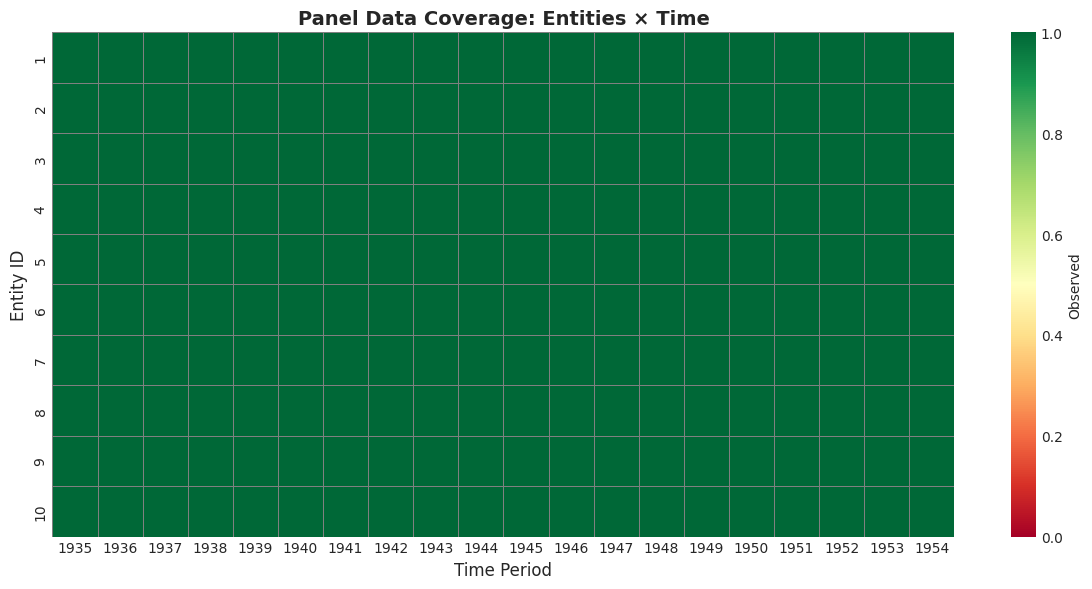


Green cells = observed | Red cells = missing


In [8]:
# Create heatmap of panel coverage
pivot_table = panel.data.pivot_table(
    index=entity_col,
    columns=time_col,
    values='invest',  # Use any variable as indicator
    aggfunc='count'
)

# Replace counts with 1 (observed) and NaN with 0 (missing)
coverage = pivot_table.notna().astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(coverage, cmap='RdYlGn', cbar_kws={'label': 'Observed'},
            linewidths=0.5, linecolor='gray', vmin=0, vmax=1)
plt.title('Panel Data Coverage: Entities × Time', fontsize=14, fontweight='bold')
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Entity ID', fontsize=12)
plt.tight_layout()
plt.show()

print("\nGreen cells = observed | Red cells = missing")

## 4. Data Transformations

Panel data often requires transformations to:
- Remove unobserved heterogeneity (entity fixed effects)
- Study changes over time (first differences)
- Create lagged variables (dynamics)

### Common Transformations

1. **Demeaning (within transformation)**:
   $$\tilde{Y}_{it} = Y_{it} - \bar{Y}_i$$
   - Removes entity-specific means
   - Used in Fixed Effects estimation

2. **First Differences**:
   $$\Delta Y_{it} = Y_{it} - Y_{i,t-1}$$
   - Removes time-invariant entity effects
   - Used in First Difference estimation

3. **Time Demeaning**:
   $$\tilde{Y}_{it} = Y_{it} - \bar{Y}_t$$
   - Removes time-specific means
   - Used to control for time effects

4. **Lags**:
   $$Y_{i,t-1}, Y_{i,t-2}, \ldots$$
   - Used in dynamic models

---

In [9]:
# Demeaning (within transformation)
print("="*60)
print("ENTITY DEMEANING (WITHIN TRANSFORMATION)")
print("="*60)

# Select a variable to demean (e.g., 'invest')
var = 'invest'

# Calculate entity means
entity_means = panel.data.groupby(entity_col)[var].transform('mean')

# Calculate demeaned values
panel.data[f'{var}_demeaned'] = panel.data[var] - entity_means

# Display example
sample_firm = panel.data[entity_col].iloc[0]
sample_data = panel.data[panel.data[entity_col] == sample_firm][[
    time_col, var, f'{var}_demeaned'
]].head(10)

print(f"\nExample: Firm '{sample_firm}'")
print(f"Original vs Demeaned '{var}':\n")
display(sample_data)

print(f"\n✓ Demeaned variable created: '{var}_demeaned'")
print(f"  Interpretation: Deviation from firm-specific mean investment")

ENTITY DEMEANING (WITHIN TRANSFORMATION)

Example: Firm '1'
Original vs Demeaned 'invest':



,year,invest,invest_demeaned
0,1935,317.6,-290.42
1,1936,391.8,-216.22
2,1937,410.6,-197.42
3,1938,257.7,-350.32
4,1939,330.8,-277.22
5,1940,461.2,-146.82
6,1941,512.0,-96.02
7,1942,448.0,-160.02
8,1943,499.6,-108.42
9,1944,547.5,-60.52



✓ Demeaned variable created: 'invest_demeaned'
  Interpretation: Deviation from firm-specific mean investment


In [10]:
# First differences
print("\n" + "="*60)
print("FIRST DIFFERENCES")
print("="*60)

# Calculate first differences (within each entity)
panel.data[f'{var}_diff'] = panel.data.groupby(entity_col)[var].diff()

# Display example
sample_data = panel.data[panel.data[entity_col] == sample_firm][[
    time_col, var, f'{var}_diff'
]].head(10)

print(f"\nExample: Firm '{sample_firm}'")
print(f"Original vs First Difference of '{var}':\n")
display(sample_data)

print(f"\n✓ First difference variable created: '{var}_diff'")
print(f"  Interpretation: Change in investment from previous year")
print(f"  Note: First observation per entity is NaN (no t-1)")


FIRST DIFFERENCES

Example: Firm '1'
Original vs First Difference of 'invest':



,year,invest,invest_diff
0,1935,317.6,NaN
1,1936,391.8,74.2
2,1937,410.6,18.8
3,1938,257.7,-152.9
4,1939,330.8,73.1
5,1940,461.2,130.4
6,1941,512.0,50.8
7,1942,448.0,-64.0
8,1943,499.6,51.6
9,1944,547.5,47.9



✓ First difference variable created: 'invest_diff'
  Interpretation: Change in investment from previous year
  Note: First observation per entity is NaN (no t-1)


In [11]:
# Lagged variables
print("\n" + "="*60)
print("LAGGED VARIABLES")
print("="*60)

# Create lag (within each entity)
panel.data[f'{var}_lag1'] = panel.data.groupby(entity_col)[var].shift(1)
panel.data[f'{var}_lag2'] = panel.data.groupby(entity_col)[var].shift(2)

# Display example
sample_data = panel.data[panel.data[entity_col] == sample_firm][[
    time_col, var, f'{var}_lag1', f'{var}_lag2'
]].head(10)

print(f"\nExample: Firm '{sample_firm}'")
print(f"Original, Lag 1, and Lag 2 of '{var}':\n")
display(sample_data)

print(f"\n✓ Lagged variables created: '{var}_lag1', '{var}_lag2'")
print(f"  Interpretation: Investment in previous years")
print(f"  Note: First observation(s) per entity are NaN")


LAGGED VARIABLES

Example: Firm '1'
Original, Lag 1, and Lag 2 of 'invest':



,year,invest,invest_lag1,invest_lag2
0,1935,317.6,NaN,NaN
1,1936,391.8,317.6,NaN
2,1937,410.6,391.8,317.6
3,1938,257.7,410.6,391.8
4,1939,330.8,257.7,410.6
5,1940,461.2,330.8,257.7
6,1941,512.0,461.2,330.8
7,1942,448.0,512.0,461.2
8,1943,499.6,448.0,512.0
9,1944,547.5,499.6,448.0



✓ Lagged variables created: 'invest_lag1', 'invest_lag2'
  Interpretation: Investment in previous years
  Note: First observation(s) per entity are NaN


In [12]:
# Time demeaning
print("\n" + "="*60)
print("TIME DEMEANING")
print("="*60)

# Calculate time-period means
time_means = panel.data.groupby(time_col)[var].transform('mean')

# Calculate time-demeaned values
panel.data[f'{var}_time_demeaned'] = panel.data[var] - time_means

# Display example for a specific year
sample_year = panel.data[time_col].iloc[0]
sample_data = panel.data[panel.data[time_col] == sample_year][[
    entity_col, var, f'{var}_time_demeaned'
]].head(10)

print(f"\nExample: Year '{sample_year}'")
print(f"Original vs Time-Demeaned '{var}':\n")
display(sample_data)

print(f"\n✓ Time-demeaned variable created: '{var}_time_demeaned'")
print(f"  Interpretation: Deviation from year-specific mean investment")


TIME DEMEANING

Example: Year '1935'
Original vs Time-Demeaned 'invest':



,firm,invest,invest_time_demeaned
0,1,317.60,243.815
20,2,209.90,136.115
40,3,33.10,-40.685
60,4,40.29,-33.495
80,5,39.68,-34.105
100,6,20.36,-53.425
120,7,24.43,-49.355
140,8,12.93,-60.855
160,9,26.63,-47.155
180,10,12.93,-60.855



✓ Time-demeaned variable created: 'invest_time_demeaned'
  Interpretation: Deviation from year-specific mean investment


## 5. Visualization Techniques

Visualizing panel data helps identify:
- Trends over time (within entities)
- Variation across entities (cross-sectional heterogeneity)
- Outliers and anomalies
- Appropriateness of model assumptions

---

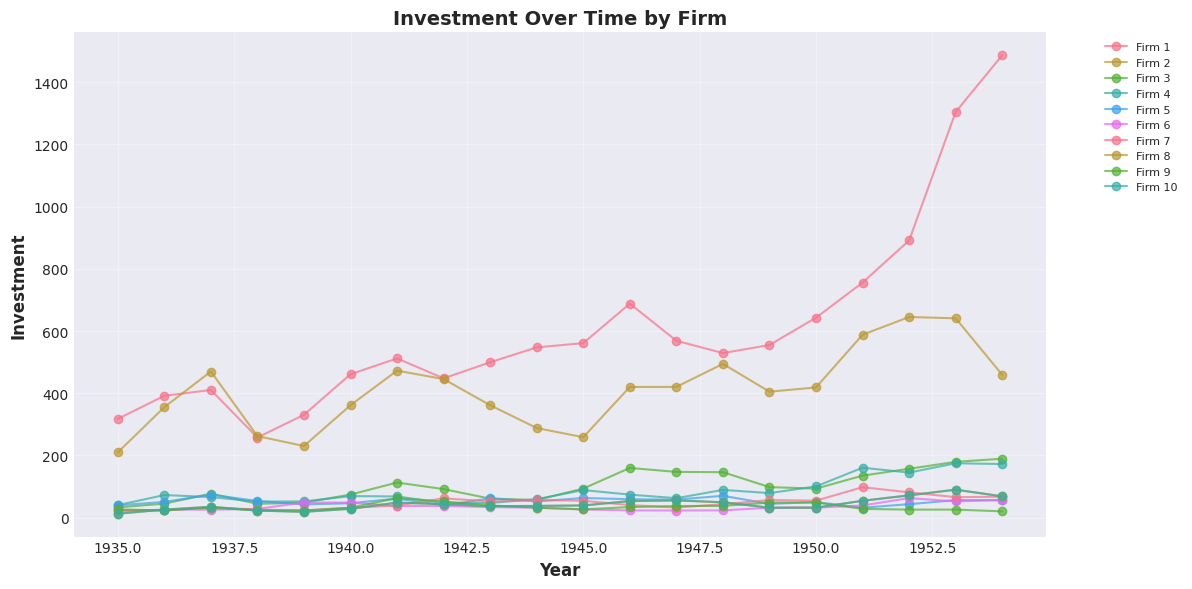

Observation: Note the firm-specific levels and trends


In [13]:
# Plot time series for each entity
fig, ax = plt.subplots(figsize=(12, 6))

for entity in panel.data[entity_col].unique():
    entity_data = panel.data[panel.data[entity_col] == entity]
    ax.plot(entity_data[time_col], entity_data[var], marker='o', label=f'Firm {entity}', alpha=0.7)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Investment', fontsize=12, fontweight='bold')
ax.set_title('Investment Over Time by Firm', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Observation: Note the firm-specific levels and trends")

/tmp/ipykernel_1576015/1445294393.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_plot, labels=entity_order, patch_artist=True)


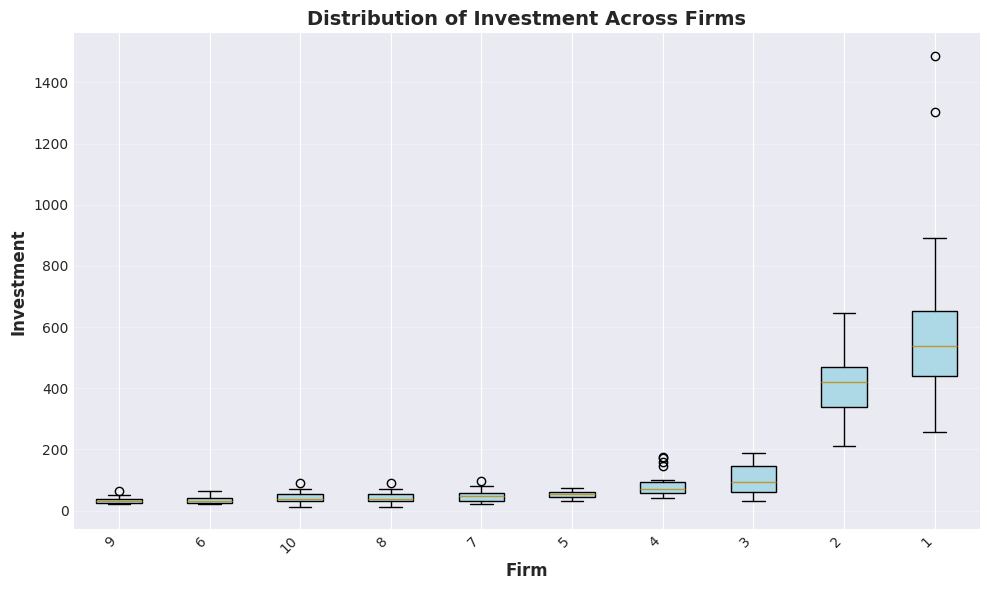

Observation: Note the cross-sectional heterogeneity (different firm sizes)


In [14]:
# Box plot: distribution of variable across entities
fig, ax = plt.subplots(figsize=(10, 6))

entity_order = panel.data.groupby(entity_col)[var].median().sort_values().index
data_for_plot = [panel.data[panel.data[entity_col] == e][var].values
                 for e in entity_order]

bp = ax.boxplot(data_for_plot, labels=entity_order, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

ax.set_xlabel('Firm', fontsize=12, fontweight='bold')
ax.set_ylabel('Investment', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Investment Across Firms', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Observation: Note the cross-sectional heterogeneity (different firm sizes)")

VARIANCE DECOMPOSITION: WITHIN vs BETWEEN

Variable: 'invest'

Total variance:   46685.16
Between variance: 39232.93 (84.0%)
Within variance:  11142.09 (23.9%)


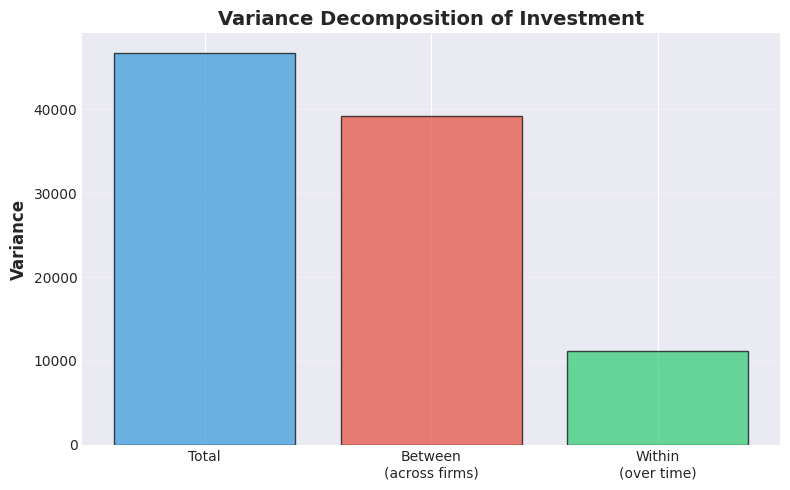


Interpretation:
  - High between variance → Firms are very different from each other
  - High within variance → Variables change a lot over time within firms


In [15]:
# Decompose variance: within vs between
print("="*60)
print("VARIANCE DECOMPOSITION: WITHIN vs BETWEEN")
print("="*60)

# Overall variance
total_var = panel.data[var].var()

# Between variance (variance of entity means)
entity_means_series = panel.data.groupby(entity_col)[var].mean()
between_var = entity_means_series.var()

# Within variance (average variance within entities)
def within_variance(group):
    return ((group - group.mean())**2).mean()

within_var = panel.data.groupby(entity_col)[var].apply(within_variance).mean()

print(f"\nVariable: '{var}'")
print(f"\nTotal variance:   {total_var:.2f}")
print(f"Between variance: {between_var:.2f} ({100*between_var/total_var:.1f}%)")
print(f"Within variance:  {within_var:.2f} ({100*within_var/total_var:.1f}%)")

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
variances = [total_var, between_var, within_var]
labels = ['Total', 'Between\n(across firms)', 'Within\n(over time)']
colors = ['#3498db', '#e74c3c', '#2ecc71']

ax.bar(labels, variances, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Variance', fontsize=12, fontweight='bold')
ax.set_title('Variance Decomposition of Investment', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - High between variance → Firms are very different from each other")
print("  - High within variance → Variables change a lot over time within firms")

## 6. Practical Exercises

Test your understanding with these hands-on exercises. Solutions are available in `solutions/01_fundamentals/01_introduction_solutions.ipynb`.

### Exercise 1: Load and Inspect Another Variable

**Task**: Analyze the `value` variable instead of `invest`.
1. Calculate entity means for `value`
2. Create a time series plot
3. Compute variance decomposition (within vs between)

**Hint**: Reuse the code from Section 4 and 5, changing the variable name.

---

### Exercise 2: Create More Complex Transformations

**Task**: Create the following transformations for the `capital` variable:
1. Log transformation: `log_capital`
2. Growth rate: `capital_growth` (percent change from t-1)
3. 3-year moving average: `capital_ma3`

**Hint**: Use `np.log()`, `.pct_change()`, and `.rolling(window=3).mean()`

---

### Exercise 3: Identify Outliers

**Task**: Find entity-year observations with extreme investment values.
1. Calculate z-scores for `invest` (standardized values)
2. Identify observations with |z-score| > 2.5
3. Create a scatter plot highlighting these outliers

**Hint**: z-score = (X - mean) / std

---

### Exercise 4: Panel Balance Check

**Task**: Simulate an unbalanced panel and validate it.
1. Remove 10% of observations randomly from the Grunfeld dataset
2. Create a new `PanelData` object
3. Check if it's balanced
4. Visualize the coverage heatmap

**Hint**: Use `data.sample(frac=0.9)` to remove 10% randomly

---

In [16]:
# Exercise 1: Your code here
# -------------------------

# Your solution for Exercise 1

In [17]:
# Exercise 2: Your code here
# -------------------------

# Your solution for Exercise 2

In [18]:
# Exercise 3: Your code here
# -------------------------

# Your solution for Exercise 3

In [19]:
# Exercise 4: Your code here
# -------------------------

# Your solution for Exercise 4

## 7. Summary and Next Steps

### What You Learned

In this tutorial, you learned:

✅ **What panel data is**: Cross-sectional + time dimensions

✅ **How to load data**: Using `PanelData` class

✅ **Panel validation**: Balanced vs unbalanced panels

✅ **Common transformations**: Demeaning, differencing, lags

✅ **Visualization**: Time series, cross-sections, variance decomposition

### Key Takeaways

1. **Panel data adds richness**: More observations, control for unobserved heterogeneity
2. **Structure matters**: Balanced vs unbalanced affects estimation
3. **Transformations are essential**: Remove entity/time effects, create dynamics
4. **Visualize first**: Understand your data before modeling

---

### Next Steps

You are now ready to move to the next tutorial:

**Tutorial 02: Model Specification with Formulas**
- Learn R-style formula syntax
- Specify econometric models
- Add transformations, interactions, and polynomials

**File**: `02_formulas_specification.ipynb`

---

### Additional Resources

- **PanelBox Documentation**: https://panelbox.readthedocs.io
- **Wooldridge (2010)**: "Econometric Analysis of Cross Section and Panel Data" (MIT Press)
- **Baltagi (2021)**: "Econometric Analysis of Panel Data" (Springer)
- **Grunfeld (1958)**: Original investment study

---

### Feedback

Found an issue or have suggestions? Please open an issue at:
https://github.com/panelbox/panelbox/issues

---

In [20]:
# Session information
import matplotlib

print("="*60)
print("SESSION INFORMATION")
print("="*60)
print(f"\nNotebook: 01_introduction_panel_data.ipynb")
print(f"Version: {__version__}")
print(f"Last updated: {__last_updated__}")
print(f"\nLibrary versions:")
print(f"  PanelBox: {pb.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  Pandas: {pd.__version__}")
print(f"  Matplotlib: {matplotlib.__version__}")
print(f"  Seaborn: {sns.__version__}")
print("\nTutorial completed successfully! 🎉")

SESSION INFORMATION

Notebook: 01_introduction_panel_data.ipynb
Version: 1.0.0
Last updated: 2026-02-16

Library versions:
  PanelBox: 1.0.0
  NumPy: 2.4.1
  Pandas: 2.3.3
  Matplotlib: 3.10.8
  Seaborn: 0.13.2

Tutorial completed successfully! 🎉
